In [43]:
# Setup
import sys
import numpy as np
import tensorflow as tf
import Utils.PokemonUtils as pkmnUtils
from matplotlib import pyplot as plt
from Models import Baseline
import importlib
import tflearn

utils = pkmnUtils.PokemonUtils(rel_loc="")

# Only run if split file has not already been generated
if False:
    utils.loadAllGIFs()
    
utils.localLoadAllGifs("Data/SplitsV2.npz")
x_train, x_val, x_test, y_train, y_val, y_test = utils.getSplits()

USE_GPU = False
device = '/cpu:0'
if USE_GPU:
    device = '/device:GPU:0'

def trainBatches(batch_size):
    for batch in range(int(len(x_train) / batch_size)):
        yield x_train[batch * batch_size: (batch + 1) * batch_size], y_train[batch * batch_size: (batch + 1) * batch_size]

def valBatches(batch_size):
    for batch in range(int(len(x_val) / batch_size)):
        yield x_val[batch * batch_size: (batch + 1) * batch_size], y_val[batch * batch_size: (batch + 1) * batch_size]

def testBatches(batch_size):
    for batch in range(int(len(x_test) / batch_size)):
        yield x_test[batch * batch_size: (batch + 1) * batch_size], y_test[batch * batch_size: (batch + 1) * batch_size]

x_train: (6010, 128, 128, 4)
x_val:   (1510, 128, 128, 4)
x_test:  (1880, 128, 128, 4)
y_train: (6010,)
y_val:   (1510,)
y_test:  (1880,)


In [ ]:
# Run on PokemonUtils update
import Utils.PokemonUtils as pkmnUtils
importlib.reload(pkmnUtils)  # update import if PokemonUtils.py changes
utils = pkmnUtils.PokemonUtils(utils=utils)

In [63]:
# Run on model update
from Models import Baseline
importlib.reload(Baseline)

<module 'Models.Baseline' from '/home/benjaminshare/pokemon-learning/Models/Baseline.py'>

In [5]:
def check_accuracy(sess, dset, x, scores, verbose=True):
    num_correct, num_samples = 0, 0
    for x_batch, y_batch in dset:
        feed_dict = {x: x_batch, is_training: 0}
        scores_np = sess.run(scores, feed_dict=feed_dict)
        y_pred = scores_np.argmax(axis=1)
        num_samples += x_batch.shape[0]
        num_correct += (y_pred == y_batch).sum()
    acc = float(num_correct) / num_samples
    if verbose:
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    return acc

In [65]:
# tflearn version
# Train model
net = Baseline.ShallowNet()
num_epochs = 5
learning_rate = 5e-4
batch_size = 16
print_every = 10
reg_weight = 3e-2
DEBUG = False

# tf.reset_default_graph()

# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())

with tf.device(device):
    m = net.tflearn_model()
    model = tflearn.models.dnn.DNN(m)
    model.fit({'input': x_train}, {'target': y_train}, n_epoch=2, validation_set=({'input': x_val}, {'target': y_val}), batch_size=batch_size)
    

---------------------------------
Run id: Y7SV20
Log directory: /tmp/tflearn_logs/


Exception in thread Thread-45:
Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/tflearn/data_flow.py", line 191, in fill_feed_dict_queue
    data[k] = self.daug_dict[k].apply(data[k])
KeyError: <tf.Tensor 'input_5/X:0' shape=(?, 128, 128, 4) dtype=float32>

Exception in thread Thread-47:
Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/tflearn/data_flow.py", line 191, in fill_feed_dict_queue
    data[k] = self.daug_dict[k].apply(data[k])
KeyError: <t

---------------------------------
Training samples: 48080
Validation samples: 12080
--


KeyboardInterrupt: 

In [6]:
# Train model
model = Baseline.ShallowNet()
num_epochs = 5
learning_rate = 5e-4
batch_size = 16
print_every = 10
reg_weight = 3e-2
DEBUG = False

tf.reset_default_graph()    
with tf.device(device):
    x = tf.placeholder(tf.float32, [None, 128, 128, 4])
    y = tf.placeholder(tf.int32, [None])

    is_training = tf.placeholder(tf.bool, name='is_training')

    partials, scores = model.model_init_fn(x, beta=reg_weight)

    error_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.reduce_mean(error_loss + sum(reg_losses))

    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(loss)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        t = 0
        acc_checks = []
        train_accs = []
        val_accs = []
        err_vals = []
        reg_vals = []
        for epoch in range(num_epochs):
            print('Starting epoch %d' % epoch)
            for x_batch, y_batch in trainBatches(batch_size):
                feed_dict = {x: x_batch, y: y_batch, is_training:1}
                if DEBUG:
                    loss_np, _, p0, p1, p2, p3 = sess.run([loss, train_op, partials[0], partials[1], partials[2], partials[3]], feed_dict=feed_dict)
                    print("p0:", p0.shape)
                    print("p1:", p1.shape)
                    print("p2:", p2.shape)
                    print("p3:", p3.shape)
                else:
                    loss_np, el, rl, _ = sess.run([loss, error_loss, reg_losses, train_op], feed_dict=feed_dict)
                if t % print_every == 0:
                    print('Iteration %d, loss = %.4f' % (t, loss_np))
                    acc_checks.append(t)
                    train_accs.append(check_accuracy(sess, trainBatches(batch_size), x, scores, verbose=False))
                    val_accs.append(check_accuracy(sess, valBatches(batch_size), x, scores))
                    err_vals.append(tf.reduce_mean(el).eval())
                    reg_vals.append(sum(rl))
                    print()
                t += 1
                    

Starting epoch 0
Iteration 0, loss = 39.7100
Got 50 / 1504 correct (3.32%)

Iteration 10, loss = 9.1396
Got 89 / 1504 correct (5.92%)

Iteration 20, loss = 7.7330
Got 85 / 1504 correct (5.65%)

Iteration 30, loss = 7.2204
Got 85 / 1504 correct (5.65%)

Iteration 40, loss = 7.2228
Got 99 / 1504 correct (6.58%)

Iteration 50, loss = 7.7242
Got 92 / 1504 correct (6.12%)

Iteration 60, loss = 9.0534
Got 93 / 1504 correct (6.18%)

Iteration 70, loss = 7.9324
Got 98 / 1504 correct (6.52%)

Iteration 80, loss = 7.8034
Got 108 / 1504 correct (7.18%)

Iteration 90, loss = 7.2889
Got 122 / 1504 correct (8.11%)

Iteration 100, loss = 7.2278
Got 118 / 1504 correct (7.85%)

Iteration 110, loss = 7.3532
Got 132 / 1504 correct (8.78%)

Iteration 120, loss = 7.5057
Got 123 / 1504 correct (8.18%)

Iteration 130, loss = 7.4148
Got 124 / 1504 correct (8.24%)

Iteration 140, loss = 7.0812
Got 137 / 1504 correct (9.11%)

Iteration 150, loss = 7.8249
Got 127 / 1504 correct (8.44%)

Iteration 160, loss = 8.1

KeyboardInterrupt: 

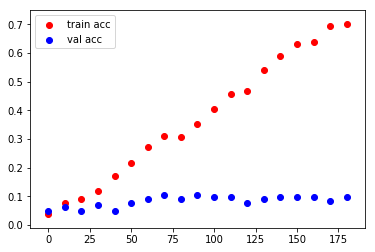

In [89]:
# Print training losses on train/val sets
plt.figure()
plt.scatter(acc_checks, train_accs, c='red')
plt.scatter(acc_checks, val_accs, c='blue')
plt.legend(["train acc", "val acc"])
plt.savefig("Results/training_loss_%.2freg.jpg" %reg_weight)

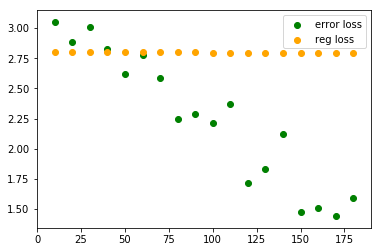

In [90]:
plt.figure()
plt.scatter(acc_checks[1:], err_vals[1:], c='green')
plt.scatter(acc_checks[1:], reg_vals[1:], c='orange')
plt.legend(["error loss", "reg loss"])
plt.savefig("Results/relative_losses_%.2freg.jpg" %reg_weight)

In [ ]:
# Test model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = tf.placeholder(tf.float32, [None, 128, 128, 4])
    _, scores = model.model_init_fn(x)
    
    check_accuracy(sess, testBatches(batch_size), x, scores)
acc = None
pass
print(acc)